In [ ]:
!pip install tensorflow scikit-learn

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix, precision_score, recall_score, accuracy_score

In [ ]:
df = pd.read_csv("drive/MyDrive/School/Y3S2/AAP/combined_posts_final_cleaned.csv")
print(df.shape)
df

(51725, 9)


,Title,Replies,Category,Rep Count,Post Content,tokenized words,Days Since Post,tokenized title,Engagement
0,Economics Igcse,0,GCSE,0.0,Hi I'm currently taking the edexcel economics ...,"['hi', 'currently', 'taking', 'economics', 'co...",1,['economics'],Unpopular
1,GCSE 2004 born 1987/88 Exam board Essex,1,GCSE,0.0,Does anyone know which exam board they sat the...,"['anyone', 'know', 'exam', 'board', 'sat', 'la...",1,"['born', 'exam', 'board']",Unpopular
2,Need help with inconsistent motivation,1,GCSE,0.0,Hiya. I'm in Year 11 and I did 3 GCSE exams in...,"['year', 'year', 'biology', 'astronomy', 'lite...",1,"['need', 'help', 'inconsistent', 'motivation']",Unpopular
3,"I got 99999999888 at GCSE, ask me anything ‼️",29,GCSE,2.0,I got:\n\nMaths - 9\nPhysics-9 \nChemistry- 9 ...,"['got', 'seeking', 'advice', 'feel', 'free', '...",1,"['got', 'ask', 'anything']",Popular
4,How to study English,11,GCSE,1.0,I am getting 3s but I need to get at least 5s,"['getting', 'need', 'get', 'least']",1,['study'],Popular
...,...,...,...,...,...,...,...,...,...
51720,Lilians's revision tips [TSR video panel],0,Study Support,1.0,[CENTER][youtube]4KRzYtES-24[/youtube]\n\nLili...,"['center', 'top', 'revision', 'get', 'plan', '...",5038,"['revision', 'video', 'panel']",Unpopular
51721,Megan's revision tips [TSR video panel],0,Study Support,0.0,[CENTER][youtube]KLUo6soBUfU[/youtube]\n\nMega...,"['center', 'top', 'revision', 'create', 'mind'...",5038,"['revision', 'video', 'panel']",Unpopular
51722,Nick's revision tips [TSR video panel],0,Study Support,1.0,[CENTER][youtube]fjQaQMga9IY[/youtube]\n\nNick...,"['center', 'top', 'revision', 'write', 'listen...",5038,"['nick', 'revision', 'video', 'panel']",Unpopular
51723,Rory's revision tips [TSR video panel],0,Study Support,9.0,[CENTER][youtube]3BFeHtuJz50[/youtube]\n\nRory...,"['center', 'top', 'revision', 'past', 'paper',...",5038,"['rory', 'revision', 'video', 'panel']",Decent


In [ ]:
sampled_df = df.sample(n=1000, random_state=42)
golden_df = pd.DataFrame(columns=df.columns)
golden_df = pd.concat([golden_df, sampled_df], ignore_index=True)

df = df.drop(sampled_df.index).reset_index(drop=True)

# Check sizes of both datasets
print(f"Golden dataset size: {golden_df.shape}")
print(f"Updated df size: {df.shape}")

Golden dataset size: (1000, 9)
Updated df size: (50725, 9)


<ipython-input-4-30e3fe1b1245>:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  golden_df = pd.concat([golden_df, sampled_df], ignore_index=True)


In [ ]:
golden_df.to_csv("/content/drive/MyDrive/School/Y3S2/AAP/golden_dataset.csv", index = False)

### Calculate token counts for title and post content
**We will use these values for max sequence and title length**

In [ ]:
vocab_size = 10000

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['Post Content'].astype(str))

text_sequences = tokenizer.texts_to_sequences(df['Post Content'].astype(str))

# Count the number of tokens (length of each sequence)
token_counts = [len(seq) for seq in text_sequences]

# Calculate the 95th percentile of token counts
percentile_95_post_content = round(np.percentile(token_counts, 95))

print(f"95th Percentile of Token Counts for Post Content: {percentile_95_post_content}")

95th Percentile of Token Counts for Post Content: 233


In [ ]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['Title'].astype(str))

text_sequences = tokenizer.texts_to_sequences(df['Title'].astype(str))

# Count the number of tokens (length of each sequence)
token_counts = [len(seq) for seq in text_sequences]

# Calculate the 95th percentile of token counts
percentile_95_title = round(np.percentile(token_counts, 95))

print(f"95th Percentile of Token Counts for Title: {percentile_95_title}")

95th Percentile of Token Counts for Title: 13


### Quick Dataprep

In [ ]:
category_encoder = OneHotEncoder(sparse_output=False) #No need for drop first param as it can reduce representational power of nn model
category_encoded = category_encoder.fit_transform(df['Category'].values.reshape(-1, 1))

print(f"Encoded Categories:\n{category_encoded[:5]}")

Encoded Categories:
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


In [ ]:
vocab_size = 10000
max_sequence_length = percentile_95_post_content  #Max length for padding
embedding_dim = 128

text_data = df['Post Content'].astype(str)

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(text_data)
text_sequences = tokenizer.texts_to_sequences(text_data)
text_padded = pad_sequences(text_sequences, maxlen=max_sequence_length, padding="post")

print(f"Tokenized and Padded Text Data:\n{text_padded[:3]}")

Tokenized and Padded Text Data:
[[  79   33  135  178    5  200  227  472  187    4   33   31  144   26
    13   85    5  460   27  255  492   86    2 4777   72  169  146   11
    13    4   21    5  160  922   12   13   13  516   49  102   70    4
    33 1146   19    3   30   18  644    5 1694   11   13   14    1  350
    20    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0 

In [ ]:
max_title_length = percentile_95_title  #Max length for padding

title_data = df['Title'].astype(str)

title_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
title_tokenizer.fit_on_texts(title_data)

title_sequences = title_tokenizer.texts_to_sequences(title_data)
title_padded = pad_sequences(title_sequences, maxlen=max_title_length)

print(f"Padded Titles: {title_padded[:3]}")

Padded Titles: [[   0    0    0    0    0    0    0    0    0    0    0   83   64]
 [   0    0    0    0    0    5 3640 3641 5921 4419   20  357 3138]
 [   0    0    0    0    0    0    0    0   48    8   35 5922  157]]


In [ ]:
# Normalize Days Since Post
scaler = MinMaxScaler()
days_scaled = scaler.fit_transform(df['Days Since Post'].values.reshape(-1, 1))

print("Scaled Days Since Post:")
print(days_scaled)

Scaled Days Since Post:
[[0.       ]
 [0.       ]
 [0.       ]
 ...
 [0.6593795]
 [0.6593795]
 [1.       ]]


In [ ]:
# Encode Engagement (target variable)
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(df['Engagement'])

print("Encoded Categories:")
print(labels_encoded[:5])

print("Class Mapping:")
print(dict(zip(encoder.classes_, range(len(encoder.classes_)))))

Encoded Categories:
[2 2 2 1 1]
Class Mapping:
{'Decent': 0, 'Popular': 1, 'Unpopular': 2}


### Modelling

In [ ]:
X_text_train, X_text_val, X_title_train, X_title_val, X_num_train, X_num_val, X_cat_train, X_cat_val, y_train, y_val = train_test_split(
    text_padded, title_padded, days_scaled, category_encoded, labels_encoded, test_size=0.2, random_state=42
)

In [ ]:
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(zip(np.unique(y_train), class_weights))

text_input = Input(shape=(max_sequence_length,), name="text_input")
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(text_input)
lstm_layer = LSTM(64, name="lstm_layer")(embedding_layer)

title_input = Input(shape=(max_title_length,), name="title_input")
embedding_layer_title = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_title_length)(title_input)
lstm_layer_title = LSTM(64, name="lstm_layer_title")(embedding_layer_title)


num_input = Input(shape=(1,), name="days_since_post_input") # Scalar value

cat_input = Input(shape=(4,), name="category_input")  # Shape is (4,) for one-hot encoded vector

#Combine inputs
combined = Concatenate(name="concatenate_layer")([lstm_layer, lstm_layer_title, num_input, cat_input])

dense_layer = Dense(64, activation="relu", name="dense_layer1")(combined)
dense_layer = Dropout(0.3, name="dropout_layer")(dense_layer)
output_layer = Dense(len(encoder.classes_), activation="softmax", name="output_layer")(dense_layer) # Softmax activation for multi-class classification.

model = Model(inputs=[text_input, title_input, num_input, cat_input], outputs=output_layer)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 233)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ title_input (InputLayer)  │ (None, 13)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 233, 128)       │      1,280,000 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 13, 128)        │      1,280,000 │ title_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_layer (LSTM)         │ (None, 64)             │         49,408 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_layer_title (LSTM)   │ (None, 64)             │         49,408 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ days_since_post_input     │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ category_input            │ (None, 4)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_layer         │ (None, 133)            │              0 │ lstm_layer[0][0],      │
│ (Concatenate)             │                        │                │ lstm_layer_title[0][0… │
│                           │                        │                │ days_since_post_input… │
│                           │                        │                │ category_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_layer1 (Dense)      │ (None, 64)             │          8,576 │ concatenate_layer[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_layer (Dropout)   │ (None, 64)             │              0 │ dense_layer1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer (Dense)      │ (None, 3)              │            195 │ dropout_layer[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,667,587 (10.18 MB)

 Trainable params: 2,667,587 (10.18 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
print(f"X_text_train shape: {X_text_train.shape}")
print(f"X_title_train shape: {X_title_train.shape}")
print(f"X_num_train shape: {X_num_train.shape}")
print(f"X_cat_train shape: {X_cat_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_text_train shape: (45652, 233)
X_title_train shape: (45652, 13)
X_num_train shape: (45652, 1)
X_cat_train shape: (45652, 4)
y_train shape: (45652,)


## Neural Network

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True  #rollback to the best model weights after stopping
)

history = model.fit(
    [X_text_train, X_title_train, X_num_train, X_cat_train],
    y_train,
    validation_data=([X_text_val, X_title_val, X_num_val, X_cat_val], y_val),
    epochs=20,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stopping] #Early stop if overfitting is detected
)

Epoch 1/20
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 252s 173ms/step - accuracy: 0.4037 - loss: 1.0686 - val_accuracy: 0.4865 - val_loss: 1.0086
Epoch 2/20
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 241s 169ms/step - accuracy: 0.5103 - loss: 0.9529 - val_accuracy: 0.5033 - val_loss: 0.9860
Epoch 3/20
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 255s 179ms/step - accuracy: 0.5599 - loss: 0.8630 - val_accuracy: 0.4504 - val_loss: 1.0622
Epoch 4/20
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 261s 178ms/step - accuracy: 0.5934 - loss: 0.7608 - val_accuracy: 0.4912 - val_loss: 1.0185


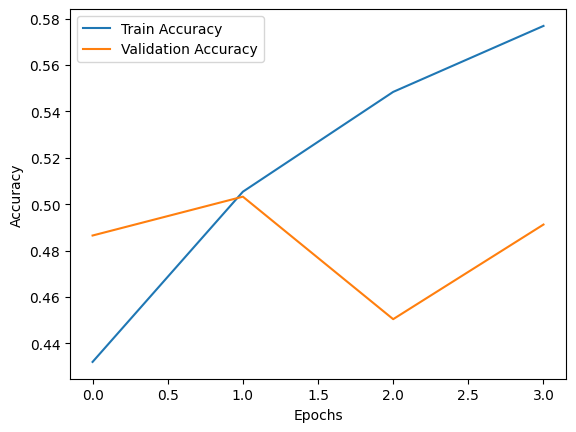

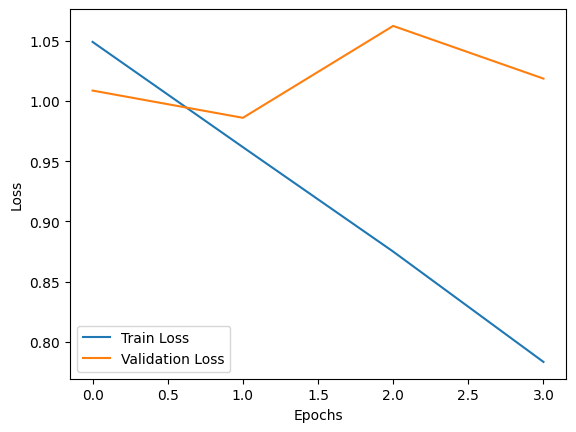

In [ ]:
import matplotlib.pyplot as plt

#Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on validation data
loss, accuracy = model.evaluate([X_text_val, X_title_val, X_num_val, X_cat_val], y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5058 - loss: 0.9869
Validation Loss: 0.9859611988067627
Validation Accuracy: 0.5032525062561035


In [ ]:
random_rows = df.sample(n=10, random_state=25)

new_posts = []
new_titles = []
new_categories = []
new_days = []

for index, row in random_rows.iterrows():
    new_posts.append(row['Post Content'])
    new_titles.append(row['Title'])
    new_categories.append(row['Category'])
    new_days.extend([1, 3, 7])

new_posts = np.array(new_posts * 3)
new_titles = np.array(new_titles * 3)
new_categories = np.array(new_categories * 3)

new_days_array = np.array(new_days).reshape(-1, 1)

new_sequences_content = tokenizer.texts_to_sequences(new_posts)
new_padded_content = pad_sequences(new_sequences_content, maxlen=max_sequence_length)

new_sequences_title = tokenizer.texts_to_sequences(new_titles)
new_padded_title = pad_sequences(new_sequences_title, maxlen=max_title_length)

new_days_scaled = scaler.transform(new_days_array)

new_categories_reshaped = np.array(new_categories).reshape(-1, 1)
new_categories_encoded = category_encoder.transform(new_categories_reshaped)

predictions = model.predict([new_padded_content, new_padded_title, new_days_scaled, new_categories_encoded])

predicted_classes = encoder.inverse_transform(np.argmax(predictions, axis=1))

predicted_classes_reshaped = predicted_classes.reshape(-1, 3)

# Output the predicted engagement categories for each post across 1 day, 3 days, and 7 days
for i, row in enumerate(random_rows.iterrows()):
    print(f"Post {i+1}: {row[1]['Title']}")
    print(f"Predicted Engagement Categories for 1 day, 3 days, and 7 days:")
    print(predicted_classes_reshaped[i])
    print("\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
Post 1: Edexcel Past papers
Predicted Engagement Categories for 1 day, 3 days, and 7 days:
['Unpopular' 'Popular' 'Unpopular']


Post 2: Edexcel alevel maths paper 1 : i want to cry
Predicted Engagement Categories for 1 day, 3 days, and 7 days:
['Unpopular' 'Unpopular' 'Popular']


Post 3: Lloyd's Emerging Talent Graduate Scheme (insurance)
Predicted Engagement Categories for 1 day, 3 days, and 7 days:
['Popular' 'Unpopular' 'Popular']


Post 4: Transferring to another college
Predicted Engagement Categories for 1 day, 3 days, and 7 days:
['Decent' 'Unpopular' 'Popular']


Post 5: How I got 99 in science in 3 months
Predicted Engagement Categories for 1 day, 3 days, and 7 days:
['Unpopular' 'Unpopular' 'Unpopular']


Post 6: How often are NEA marks changed during moderation?
Predicted Engagement Categories for 1 day, 3 days, and 7 days:
['Popular' 'Popular' 'Unpopular']


Post 7: What to do after a really bad exam?
Predicted Engagement Categories 

1427/1427 ━━━━━━━━━━━━━━━━━━━━ 54s 38ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step


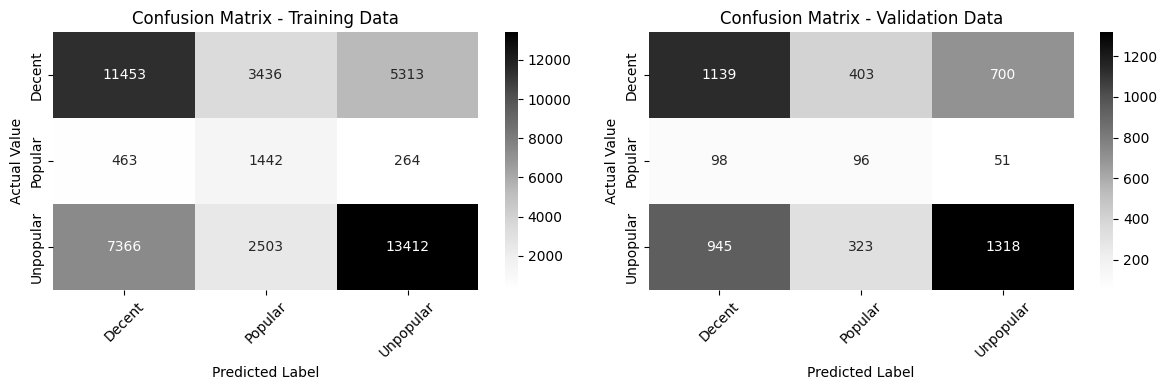

In [ ]:
y_train_pred = np.argmax(model.predict([X_text_train, X_title_train, X_num_train, X_cat_train]), axis=1)
y_val_pred = np.argmax(model.predict([X_text_val, X_title_val, X_num_val, X_cat_val]), axis=1)

cf_mat_train = confusion_matrix(y_train, y_train_pred)
cf_mat_val = confusion_matrix(y_val, y_val_pred)

class_labels = encoder.classes_

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Training Data Confusion Matrix
sns.heatmap(cf_mat_train, annot=True, fmt='g', cmap='Greys',
            xticklabels=class_labels, yticklabels=class_labels, ax=axes[0])
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("Actual Value")
axes[0].set_title("Confusion Matrix - Training Data")
axes[0].tick_params(axis='x', rotation=45)

# Validation Data Confusion Matrix
sns.heatmap(cf_mat_val, annot=True, fmt='g', cmap='Greys',
            xticklabels=class_labels, yticklabels=class_labels, ax=axes[1])
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("Actual Value")
axes[1].set_title("Confusion Matrix - Validation Data")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
print("Classification Report for Neural Network Model using Multi-Input Features")
print(classification_report(y_val, y_val_pred, target_names=encoder.classes_))

Classification Report for Neural Network Model using Multi-Input Features
              precision    recall  f1-score   support

      Decent       0.52      0.51      0.51      2242
     Popular       0.12      0.39      0.18       245
   Unpopular       0.64      0.51      0.57      2586

    accuracy                           0.50      5073
   macro avg       0.43      0.47      0.42      5073
weighted avg       0.56      0.50      0.52      5073



The neural network model demonstrates a moderate level of accuracy (54%) with varied performance across different classes.

Decent Class: shows a precision of 33%, a recall of 41%, and an f1-score of 37%, indicating that the model struggles to correctly classify most instances of this category.

Popular Class: has a significantly lower precision (9%) but a higher recall (35%), meaning it identifies many true positives but also includes a lot of false positives.

Unpopular Class: has the highest precision (78%) and an f1-score of 67%, showing the model's better performance in predicting this category, though its recall of 59% suggests room for improvement in identifying all relevant instances. Overall, the model's performance is uneven, with a stronger focus on the 'Unpopular' class.

With 2 epochs, the model demonstrates better-than-chance predictions for Unpopular and Decent posts, achieving an F1-score of 0.67 and 0.37, respectively. However, it struggles with Popular posts, with a low precision (0.09) and recall (0.35). Ultimately, the overall accuracy is 54%, suggesting the model captures some meaningful patterns but lacks balance across all classes.

## Neural Network Reattempt

From the above, we can observe that our model has started to suffer from overfitting after epoch 2. In this section, we will try to address issues by retraining the model with adjusted parameters.

✅ Changes Made:
1. Bidirectional LSTM for better sequence understanding.
2. Dropout (0.3) inside LSTM for regularization.
3. L2 regularization (l2(0.01)) on dense layers to penalize large weights.
4. Increased Dropout to 0.5 after dense layer to combat overfitting.

In [ ]:
# Text Input (Body)
text_input = Input(shape=(max_sequence_length,), name="text_input")
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(text_input)
lstm_layer = Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3))(embedding_layer)

# Title Input
title_input = Input(shape=(max_title_length,), name="title_input")
embedding_layer_title = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(title_input)
lstm_layer_title = Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3))(embedding_layer_title)

# Numerical Input
num_input = Input(shape=(1,), name="days_since_post_input")

# Categorical Input (One-hot encoded)
cat_input = Input(shape=(4,), name="category_input")

# Combine Inputs
combined = Concatenate(name="concatenate_layer")([lstm_layer, lstm_layer_title, num_input, cat_input])

# Dense Layers with L2 Regularization and Dropout
dense_layer = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(combined)
dense_layer = Dropout(0.5)(dense_layer)

# Output Layer
output_layer = Dense(len(encoder.classes_), activation="softmax", name="output_layer")(dense_layer)

# Model Compilation
model = Model(inputs=[text_input, title_input, num_input, cat_input], outputs=output_layer)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 233)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ title_input (InputLayer)  │ (None, 13)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 233, 128)       │      1,280,000 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 13, 128)        │      1,280,000 │ title_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 128)            │         98,816 │ embedding_4[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 128)            │         98,816 │ embedding_5[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ days_since_post_input     │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ category_input            │ (None, 4)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_layer         │ (None, 261)            │              0 │ bidirectional_2[0][0], │
│ (Concatenate)             │                        │                │ bidirectional_3[0][0], │
│                           │                        │                │ days_since_post_input… │
│                           │                        │                │ category_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         33,536 │ concatenate_layer[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer (Dense)      │ (None, 3)              │            387 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,791,555 (10.65 MB)

 Trainable params: 2,791,555 (10.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True  #rollback to the best model weights after stopping
)

history = model.fit(
    [X_text_train, X_title_train, X_num_train, X_cat_train],
    y_train,
    validation_data=([X_text_val, X_title_val, X_num_val, X_cat_val], y_val),
    epochs=20,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stopping] #Early stop if overfitting is detected
)

Epoch 1/20
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 905s 624ms/step - accuracy: 0.4016 - loss: 1.2968 - val_accuracy: 0.4289 - val_loss: 1.0757
Epoch 2/20
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 900s 631ms/step - accuracy: 0.4540 - loss: 1.0008 - val_accuracy: 0.4329 - val_loss: 1.0691
Epoch 3/20
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 899s 630ms/step - accuracy: 0.5067 - loss: 0.9186 - val_accuracy: 0.5127 - val_loss: 0.9395
Epoch 4/20
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 912s 639ms/step - accuracy: 0.5448 - loss: 0.8442 - val_accuracy: 0.4554 - val_loss: 1.0865
Epoch 5/20
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 913s 633ms/step - accuracy: 0.5787 - loss: 0.7578 - val_accuracy: 0.4956 - val_loss: 1.0145


In [ ]:
# Evaluate the model on validation data
loss, accuracy = model.evaluate([X_text_val, X_title_val, X_num_val, X_cat_val], y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

The reattemped model now has a better validation accuracy, compared to 0.536 previously. Let's evaluate the metrics!

In [ ]:
y_train_pred = np.argmax(model.predict([X_text_train, X_title_train, X_num_train, X_cat_train]), axis=1)
y_val_pred = np.argmax(model.predict([X_text_val, X_title_val, X_num_val, X_cat_val]), axis=1)

cf_mat_train = confusion_matrix(y_train, y_train_pred)
cf_mat_val = confusion_matrix(y_val, y_val_pred)

class_labels = encoder.classes_

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Training Data Confusion Matrix
sns.heatmap(cf_mat_train, annot=True, fmt='g', cmap='Greys',
            xticklabels=class_labels, yticklabels=class_labels, ax=axes[0])
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("Actual Value")
axes[0].set_title("Confusion Matrix - Training Data")
axes[0].tick_params(axis='x', rotation=45)

# Validation Data Confusion Matrix
sns.heatmap(cf_mat_val, annot=True, fmt='g', cmap='Greys',
            xticklabels=class_labels, yticklabels=class_labels, ax=axes[1])
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("Actual Value")
axes[1].set_title("Confusion Matrix - Validation Data")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
print("Classification Report for Neural Network Model using Multi-Input Features")
print(classification_report(y_val, y_val_pred, target_names=encoder.classes_))

Previous classification report:

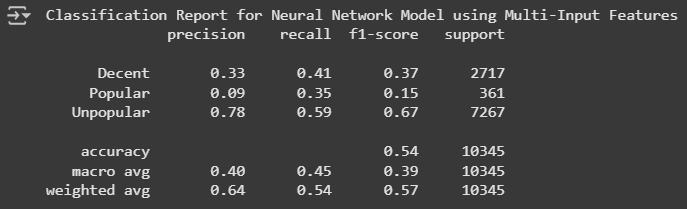

All around, our priority is to increase the F1-score to balance identifying engaging posts while avoiding promoting low-quality ones. From the metrics, we can see that the new model maintains a recall above 0.33 for both Decent and Popular posts, ensuring that we continue surfacing engaging content.

Additionally, the F1-score for Popular posts improved from 0.15 to 0.18, and overall accuracy increased from 0.54 to 0.59, demonstrating a more balanced performance.

The only issue is that precision for decent posts have decreased by .03, but the trade-off results in better recall for engaging posts, and an overall increase in accuracy. Given these improvements, I would utilise this model over the previous one. Let's go ahead and save this model.

In [ ]:
model.save('drive/MyDrive/School/Y3S2/AAP/engagement_predictor_model.keras')

## Model Classification Report

In [ ]:
# model = tf.keras.models.load_model('drive/MyDrive/School/Y3S2/AAP/engagement_predictor_model.keras')

In [ ]:
import pickle

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Post Content'].astype(str))
with open("drive/MyDrive/School/Y3S2/AAP/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

title_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
title_tokenizer.fit_on_texts(df['Title'].astype(str))
with open("drive/MyDrive/School/Y3S2/AAP/title_tokenizer.pkl", "wb") as f:
    pickle.dump(title_tokenizer, f)

print("Tokenizers saved successfully!")

In [ ]:
category_encoder = OneHotEncoder(sparse_output=False)
category_encoded = category_encoder.fit_transform(df['Category'].values.reshape(-1, 1))

with open("drive/MyDrive/School/Y3S2/AAP/category_encoder.pkl", "wb") as f:
    pickle.dump(category_encoder, f)

print("Category encoder saved successfully!")

In [ ]:
scaler = MinMaxScaler()
days_scaled = scaler.fit_transform(df['Days Since Post'].values.reshape(-1, 1))

with open("drive/MyDrive/School/Y3S2/AAP/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Scaler saved successfully!")